<a href="https://colab.research.google.com/github/RohitLad/ChestX-Ray/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Medical Diagnosis with Deep Learning

## Description

## 1. Import Packages and Functions

We would be using the following packages:
- `numpy` and `pandas` for data manipulatiuon
- `keras` for building Deep Learning models
- `matplotlib` and `seaborn` for plots

In [1]:
# Just colab things

#from google.colab import drive
#drive.mount('/content/drive')
#!cp drive/My\ Drive/Data.zip .
#import zipfile
#localZip = 'Data.zip'
#zipRef = zipfile.ZipFile(localZip, 'r')
#zipRef.extractall('')
#zipRef.close()
#!rm Data.zip
#!rm -rf 'checkPoints/*.h5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Keras modules
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## 2. Dataset Description

We shall be using a subset (~1000 images) of the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) containing 108948 frontal-view X-ray images of 32717 unique patients. The full dataset (46 GB) can be downloaded here [here](https://nihcc.app.box.com/v/ChestXray-NIHCC)

- The subset is stored in the `Data/` directory
- The images are stored in `Data/images` subdirectory
- `Data/train-small.csv`: 875 images from the dataset to be used for training
- `Data/valid-small.csv`: 109 images from dataset to be used for validation
- `Data/test-small.csv`: 420 images from dataset to be used for testing

Let's create dataframes out of the csv files

In [4]:
DataDir = "Data/"
ImageDir = DataDir+'images/'
trainDf = pd.read_csv(DataDir+'train-small.csv')
testDf = pd.read_csv(DataDir+'test.csv')
validDf = pd.read_csv(DataDir+'valid-small.csv')

trainDf.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [0]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

### Data Leakage

If a dataset contains multiple images of a same patient (because maybe the patient took X-Ray a couple of times) it should be ensured that the same patient is not present in the `test` as well as `train` sets to avoid data leakage. Let's write a function to check for data leakage (patient overlap)

In [0]:
def checkDataLeakage(df1, df2, column):
    """
        Returns true if there are common values of column in df1 and df2
        else 
        Returns False
    """
    
    unique1 = set(df1[column])
    unique2 = set(df2[column])
    
    common = unique1.intersection(unique2)
    
    return len(common)>0

In [7]:
print("Leakage between train and test sets: {}".format(checkDataLeakage(trainDf, testDf, 'PatientId')))
print("Leakage between valid and test sets: {}".format(checkDataLeakage(validDf, testDf, 'PatientId')))

Leakage between train and test sets: False
Leakage between valid and test sets: False


`False` above indicates no data leakage

### Data visualization and Preprocessing

Let's display a couple of images and investigate an image for the pixel value distribution. We shall also be preprocessing the images in order to make it easy for our classifier to train over them.

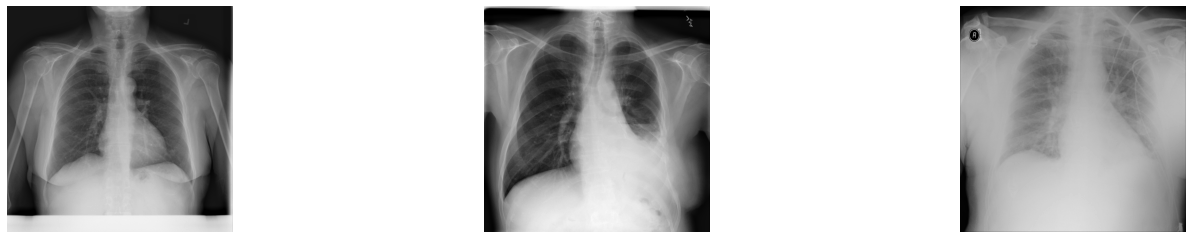

In [8]:
sampleImageVals = trainDf['Image'].values

NumImagesToDisplay = 3

randomImages = [np.random.choice(sampleImageVals) for img in range(NumImagesToDisplay)]

plt.figure(figsize=(20,10))

for i in range(NumImagesToDisplay):
    plt.subplot(3, 3, i+1)
    img = plt.imread(ImageDir+randomImages[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

Let's have a look at pixel intensity distribution

Dimensions of Image are:  (1024, 1024)
Max pixel value: 0.9804 and Min pixel value: 0.0000
Mean value: 0.4796 and Std Dev: 0.2757


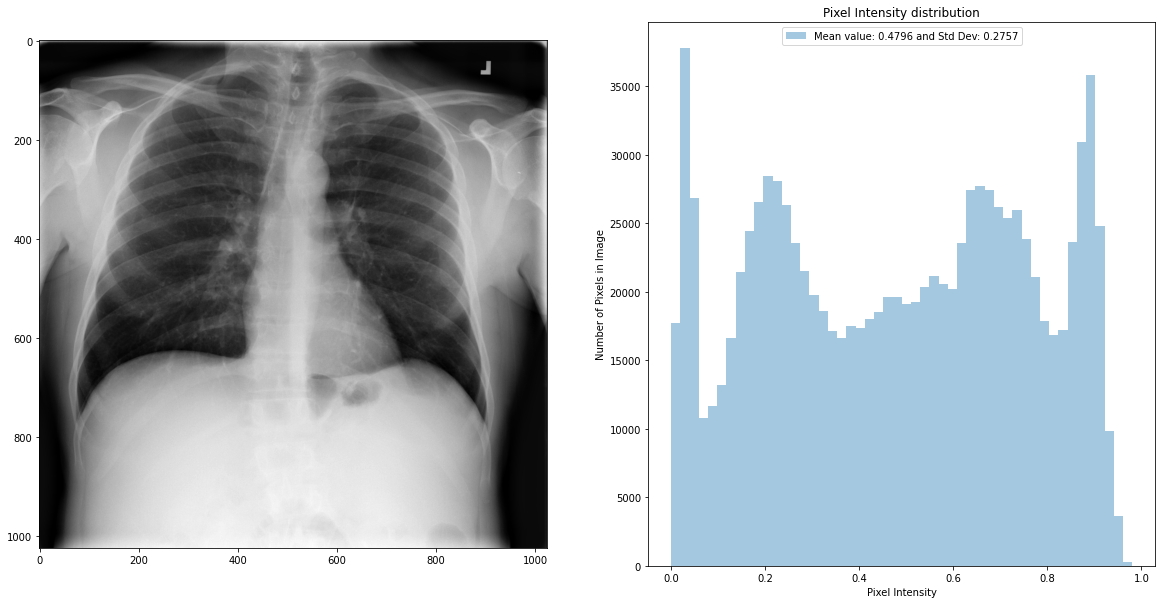

In [9]:
singleImgName = trainDf.Image[0]
singleImage = plt.imread(ImageDir+singleImgName)

def pltImgAndDist(singleImage):
    plt.figure(figsize = (20,10))
    plt.subplot(1,2,1)
    plt.imshow(singleImage, cmap='gray')
    mean = singleImage.mean()
    std = singleImage.std()
    print('Dimensions of Image are: ',singleImage.shape)
    print('Max pixel value: %.4f and Min pixel value: %.4f'%(singleImage.max(), singleImage.min()))
    string = 'Mean value: %.4f and Std Dev: %.4f'%(mean, std)
    print(string)
    
    plt.subplot(1,2,2)
    sns.distplot(singleImage.ravel(), label=string, kde=False)
    plt.legend(loc='upper center')
    plt.title('Pixel Intensity distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Number of Pixels in Image')
    
pltImgAndDist(singleImage)

As seen, the mean of the above image is skewed. It would help our classifier to normalize the above image, shift the mean to 0.0 and a unit standard deviation. One can use keras's ImageDataGenerator with active standard normalization and mean shifting, we will also set the target size to be 320* 320 pixels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 1000 validated image filenames.
Dimensions of Image are:  (320, 320, 3)
Max pixel value: 1.7999 and Min pixel value: -1.7404
Mean value: 0.0000 and Std Dev: 1.0000


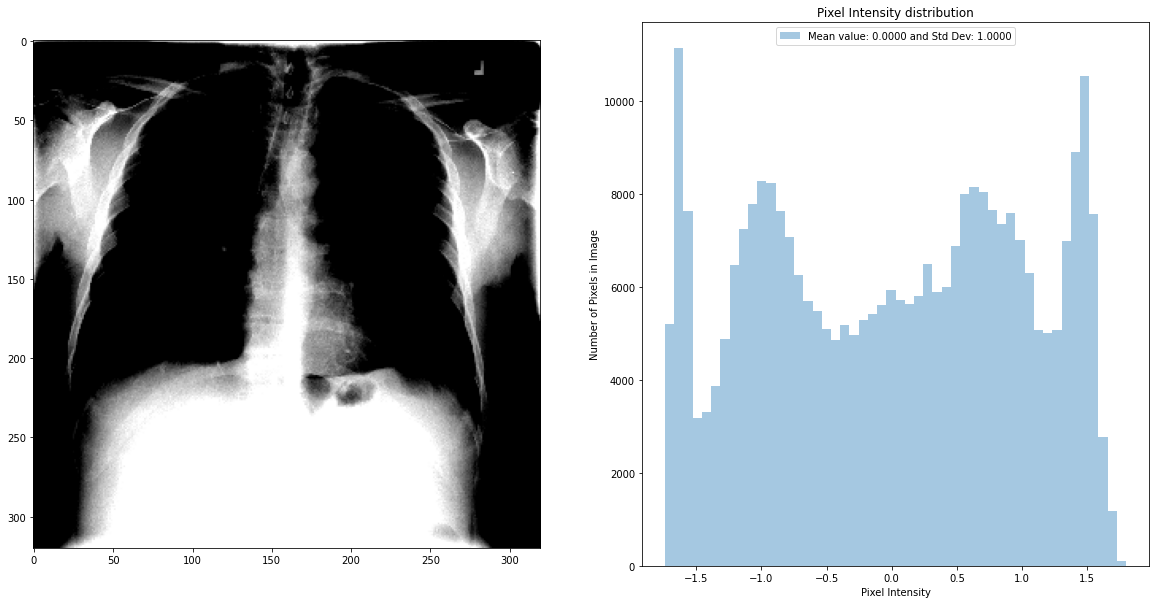

In [10]:
imageGenerator = ImageDataGenerator(
    samplewise_center=True, # mean to 0
    samplewise_std_normalization=True 
)

generator = imageGenerator.flow_from_dataframe(
    dataframe = trainDf,
    directory = ImageDir,
    x_col='Image',
    y_col=['Mass'],
    class_mode='raw',
    batch_size=1, # one image per batch
    shuffle=False,
    target_size=(320,320)
)
processedImg, label = generator.__getitem__(0)
pltImgAndDist(processedImg[0])

### Preparing Images

We would be using Keras's `ImageDataGenerator` to create data flows for training, validation and testing. The images would be
- Normalized with mean 0.0 and unit stddev
- Shuffle input after each epoch
- Set image size to 320px * 320px

The important thing here is to normalize the validation and test images w.r.t training samples

In [0]:
def getImageGenerators(TrainDf, ValidDf, TestDf, imageDir, xCol, yCols, sampleSize=100, batchSize=8, seed=42, targetW=320, targetH=320):
    
    
    def makeTrainGenerator(batch_size, imgGen=None):
        if imgGen is None:
          imgGen = ImageDataGenerator()

        trainGenerator = imgGen.flow_from_dataframe(
            dataframe=TrainDf,
            directory=imageDir,
            x_col=xCol,
            y_col=yCols,
            class_mode='raw',
            batch_size=batch_size,
            shuffle=True,
            target_size=(targetW, targetH)
        )
        return trainGenerator
    
    # sample batch from training data
    batch = makeTrainGenerator(sampleSize).next()
    dataSample = batch[0]
    
    # Fit sample to mean and std for test set generator
    imageGen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )
    
    imageGen.fit(dataSample)
    
    # create valid data generator
    validGen = imageGen.flow_from_dataframe(
        dataframe=ValidDf,
        directory=imageDir,
        x_col=xCol,
        y_col=yCols,
        class_mode='raw',
        batch_size=batchSize,
        shuffle=False,
        seed=seed,
        target_size=(targetW, targetH)
    )
    
    # create test data generator
    testGen = imageGen.flow_from_dataframe(
        dataframe=TestDf,
        directory=imageDir,
        x_col=xCol,
        y_col=yCols,
        class_mode='raw',
        batch_size=batchSize,
        shuffle=False,
        seed=seed,
        target_size=(targetW, targetH)
    )
    
    # create train data generator
    imgGenTrain = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True
    )
    trainGen = makeTrainGenerator(batchSize,imgGenTrain)
    
    return trainGen, validGen, testGen

In [12]:
trainGen, validGen, testGen = getImageGenerators(trainDf, validDf, testDf, ImageDir, 'Image', labels)

Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.
Found 1000 validated image filenames.


## 3. Model

### Data Imbalance

Let's have a look at the frequency of 'Positive' and 'Negative' instances for each label in our dataset.

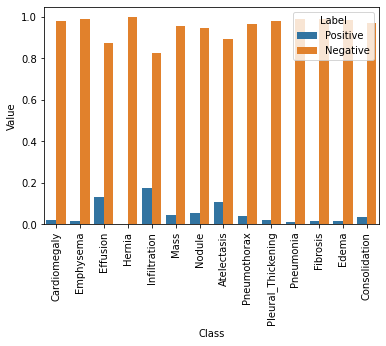

In [13]:
def calcClassFreq(labels, df):
    resultDct = {}
    resultArr = np.zeros((len(labels),2))
    for i in range(len(labels)):
        label = labels[i]
        appearances = df[label]
        pos = np.sum(appearances)/len(appearances)
        neg = 1-pos
        resultDct[label] = {'Pos':pos, 'Neg':neg}
        resultArr[i,0]=pos
        resultArr[i,1]=neg
    return resultDct, resultArr

def plotFrequencies(freqs):
    resultdf = pd.DataFrame()
    for label in freqs:
        resultdf = resultdf.append({'Class':label,'Label':'Positive','Value':freqs[label]['Pos']},ignore_index=True)
        resultdf = resultdf.append({'Class':label,'Label':'Negative','Value':freqs[label]['Neg']},ignore_index=True)
    plt.xticks(rotation=90)
    sns.barplot(x='Class',y='Value',hue='Label',data=resultdf)

frequencies,WeightsArr = calcClassFreq(labels, trainDf)
plotFrequencies(frequencies)

Ideally, the instances of `Positive` and `Negative` lebels should be same so that our model gives equal weightge to both cases, but we can use `Weighted Loss`, so that both the labels contribute equally to the loss

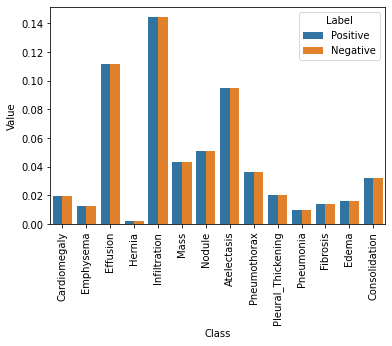

In [14]:
balancedFreqs = {}
for i in range(len(labels)):
    label = labels[i]
    posFrq = frequencies[label]['Pos']
    negFrq = frequencies[label]['Neg']
    posContrib = posFrq*WeightsArr[i,1]
    negContrib = negFrq*WeightsArr[i,0]
    balancedFreqs[label] = {'Pos':posContrib, 'Neg':negContrib}
plotFrequencies(balancedFreqs)

Therefore, as seen above, the contributions of each `Positive` and `Negative` labels are balanced if positive freq has a weight equivalent to the negative freq and vice versa

To generalize,

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

Let's write a function to model this weighted loss

In [0]:
def weightedLoss(weightsArr, eps=1e-7):
    
    wtPos = weightsArr[:,1]
    wtNeg = weightsArr[:,0]
    def weightedLoss(y_true, y_pred):
        loss = 0.0
        for i in range(len(labels)):
            loss += K.mean(-1*(wtPos[i]*y_true[:,i]*K.log(y_pred[:,i]+eps)+wtNeg[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+eps)))    
        return loss
    return weightedLoss

## Transfer Learning

Instead of training a whole deep learning model from scratch, we shall be using `Transfer Learning`. We shall be using a pretrained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model and add a couple of layers on top of it.
- A `GlobalAveragePooling2D` layer to get the average of last conv layers from DenseNet121
- A `Dense` layer with `Sigmoid` activation to get prediction logits for each of the classes


In [0]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model

In [0]:
# Use the weights of a pretrained DenseNet

model = DenseNet121(weights=DataDir+'densenet.hdf5', include_top=False)
x = model.output

# Adding a GlobalAveragePooling layer and a logistic layer
x = GlobalAveragePooling2D()(x)
x = Dense(len(labels), activation='sigmoid')(x)

model = Model(inputs=model.input, outputs=x)
model.compile(optimizer='adam', loss=weightedLoss(WeightsArr))

## Training

It's time to train the model with for the given dataset

In [0]:
import tensorflow as tf
from keras import callbacks as cb

In [19]:
callbacks = [cb.ModelCheckpoint(filepath='checkPoints/model.{epoch:02d}.h5'),
             ]

history = model.fit_generator(trainGen,
                             validation_data=validGen,
                             steps_per_epoch=100,
                             validation_steps=25,
                             epochs=50,
                             callbacks=callbacks,
                             use_multiprocessing=True,
                             workers=16)


Epoch 1/50
100/100 [==============================] - 80s 801ms/step - loss: 0.9312 - val_loss: 11.4597
Epoch 2/50
100/100 [==============================] - 39s 391ms/step - loss: 0.8414 - val_loss: 11.0492
Epoch 3/50
100/100 [==============================] - 38s 381ms/step - loss: 0.8335 - val_loss: 15.5689
Epoch 4/50
100/100 [==============================] - 38s 381ms/step - loss: 0.8780 - val_loss: 12.8606
Epoch 5/50
100/100 [==============================] - 39s 386ms/step - loss: 0.8381 - val_loss: 10.8682
Epoch 6/50
100/100 [==============================] - 36s 360ms/step - loss: 0.8422 - val_loss: 2.5759
Epoch 7/50
100/100 [==============================] - 38s 377ms/step - loss: 0.8143 - val_loss: 1.5630
Epoch 8/50
100/100 [==============================] - 38s 382ms/step - loss: 0.8249 - val_loss: 7.5781
Epoch 9/50
100/100 [==============================] - 38s 382ms/step - loss: 0.8091 - val_loss: 2.1488
Epoch 10/50
100/100 [==============================] - 38s 382ms/ste

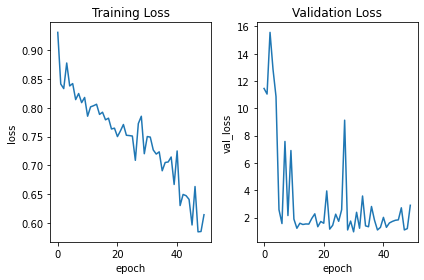

In [20]:
plt.subplot(1,2,1)
plt.title('Training Loss')
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1,2,2)
plt.title('Validation Loss')
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.tight_layout()
plt.show()

As seen above, the training loss shows a downward trend, whereas the validation loss is noisy. Training for more epochs would reduce the loss further.

In [0]:
predictedVals = model.predict_generator(testGen, steps=len(testGen))

In [0]:
from sklearn.metrics import confusion_matrix

def makeConfusionMatrix(label, yPred, yTrue, thresh=0.5):
  for index in range(len(labels)+1):
    if label==labels[index]:
      break
  assert index < len(labels)
  Ypred = np.zeros(yPred.shape[0], dtype=np.int)
  Ypred[yPred[:,index]>=thresh]=1
  Ytrue = yTrue[:,index].flatten()
  return confusion_matrix(Ytrue, Ypred).ravel()



In [23]:
tn, fp, fn, tp = makeConfusionMatrix('Mass', predictedVals, testGen.labels)
print('TrueNegative: ',tn,',  TruePositive: ',tp,', FalsePositive: ',fp,', FalseNegative: ',fn)

TrueNegative:  270 ,  TruePositive:  13 , FalsePositive:  90 , FalseNegative:  47


As seen in the above example, for a threshold of `0.5`, Correct predictions i.e. True for Positive and False for Negative have been 270+13 = 283 out of 420 test cases. 

In [26]:
tn, fp, fn, tp = makeConfusionMatrix('Infiltration', predictedVals, testGen.labels, thresh=0.8)
print('TrueNegative: ',tn,',  TruePositive: ',tp,', FalsePositive: ',fp,', FalseNegative: ',fn)

TrueNegative:  337 ,  TruePositive:  8 , FalsePositive:  24 , FalseNegative:  51
